In [75]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import compute_derivatives_2d, find_nearest_value

import scipy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from numba import njit


@njit
def upwind_2d(LHS, A, B1, B2, C1, C2, i, j, dx, dy, ϵ):
    I, J = A.shape
    loc_eq = i*J + j
    loc_xy = loc_eq
    loc_xp1y = (i+1)*J + j
    loc_xp2y = (i+2)*J + j
    loc_xm1y = (i-1)*J + j
    loc_xm2y = (i-2)*J + j
    loc_xyp1 = i*J + j+1
    loc_xyp2 = i*J + j+2
    loc_xym1 = i*J + j-1
    loc_xym2 = i*J + j-2
    LHS[loc_xy, loc_xy] += A[i, j] - 1./ϵ
    if i == 0:
        LHS[loc_eq, loc_xy] += B1[i, j] * (-1./dx) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xp1y] += B1[i, j] * (1./dx) + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xp2y] += C1[i, j] * (1./dx**2)
    elif i == I-1:
        LHS[loc_eq, loc_xy] += B1[i, j] * (1./dx) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xm1y] += B1[i, j] * (-1./dx) + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xm2y] += C1[i, j] * (1./dx**2)
    else:
        LHS[loc_eq, loc_xy] += B1[i, j] * ((-1./dx) * (B1[i, j]>0) + (1./dx) * (B1[i, j]<=0))\
                    + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xm1y] += B1[i, j] * (-1./dx) * (B1[i, j]<=0) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xp1y] += B1[i, j] * (1./dx) * (B1[i, j]>0) + C1[i, j] * (1./dx**2)
    if j == 0:
        LHS[loc_eq, loc_xy] += B2[i, j] * (-1./dy) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xyp1] += B2[i, j] * (1./dy) + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xyp2] += C2[i, j] * (1./dy**2)
    elif j == J-1:
        LHS[loc_eq, loc_xy] += B2[i, j] * (1./dy) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xym1] += B2[i, j] * (-1./dy) + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xym2] += C2[i, j] * (1./dy**2)
    else:
        LHS[loc_eq, loc_xy] += B2[i, j] * ((-1./dy) * (B2[i, j]>0) + (1./dy) * (B2[i, j]<=0))\
                    + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xym1] += B2[i, j] * (-1./dy) * (B2[i, j]<=0) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xyp1] += B2[i, j] * (1./dy) * (B2[i, j]>0) + C2[i, j] * (1./dy**2)
    return LHS


@njit
def construct_matrix_2d(A, B1, B2, C1, C2, D, dx, dy, v0, ϵ, bc, impose_bc):
    """
    boundaries = (nparray, nparray, nparray, nparray)
        (x_lower, x_upper, y_lower, y_upper)
    impose_bc = (Bool, Bool, Bool, Bool)
        if True, then the algorithm will impose user specified boundary conditions.
        otherwise the algorithm will impose natural boundary conditions.
    """
    I, J = A.shape
    LHS = np.zeros((I*J, I*J))
    RHS = - D.reshape(-1) - 1./ϵ*v0.reshape(-1)
    for i in range(I):
        for j in range(J):
            loc_eq = i*J + j
            if i == 0 and impose_bc[0]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[0][j]
            elif i == I-1 and impose_bc[1]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[1][j]
            elif j == 0 and impose_bc[2]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[2][i]
            elif j == J-1 and impose_bc[3]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[3][i]
            else:
                LHS = upwind_2d(LHS, A, B1, B2, C1, C2, i, j, dx, dy, ϵ)
    return LHS, RHS

def solver_sparse_linear_system(LHS, RHS, I, J):
    v, exitCode = bicg(csc_matrix(LHS), RHS)
    return v.reshape((I, J))

def solveFT(A, B1, B2, C1, C2, D, dx, dy, v0, ϵ, bc, impose_bc):
    I, J = A.shape
    LHS, RHS = construct_matrix_2d(A, B1, B2, C1, C2, D, dx, dy, v0, ϵ, bc, impose_bc)
    v = solver_sparse_linear_system(LHS, RHS, I, J)
    return v

In [76]:
def false_transient_one_iteration(A, B_z, B_y, C_zz, C_yy, D, v0, dx, dy, ε=.3):
    bc = tuple([np.zeros(1)]*4)
    impose_bc = tuple([False]*4)
    out = solveFT(A, B_z, B_y, C_zz, C_yy, D, dx, dy, v0, ϵ, bc, impose_bc)
    return out


def compute_prob(μ_2_state, λ_2p_state, λ_2p_prior):
    λ_2p = np.zeros(λ_2p_state.shape[0]*μ_2_state.shape[0])
    μ_2 = np.zeros_like(λ_2p)
    π_o = np.zeros_like(λ_2p)
    for i in range(λ_2p_state.shape[0]):
        for j in range(μ_2_state.shape[0]):
            idx = i*μ_2_state.shape[0] + j
            λ_2p[idx] = λ_2p_state[i]
            μ_2[idx] = μ_2_state[j]
            π_o[idx] = 1./len(μ_2_state) * λ_2p_prior[i]
    return μ_2, λ_2p, π_o

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e  + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \sum_{j}^J \pi_j \mu_{2,j}) \right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left(-\frac{1}{\xi_a}\left[(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y) z_2 e \right) + \frac{\partial \phi}{\partial z_2}(y, z_2)\rho \mu_{2,j} \right]\right)\pi_j^o
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [80]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat + λ_2p_j*(y_mat>λ_bar)*(y_mat-λ_bar) for λ_2p_j in λ_2p])
    d_Λ_z = d_Λ * z_mat

    π = np.ones_like(d_Λ)
    μ_2_new = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.    
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    e_old = e.copy()
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        log_π_ratio = -((η-1.)*d_Λ_z*e+v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()
        
        A = np.ones_like(z_mat)*(-δ)
        B_z = np.sum(π*mean, axis=0)
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*np.sum(π*d_Λ_z*e, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        v0 = false_transient_one_iteration(A, B_z, B_y, C_zz, C_yy, D, v0, Δ_z, Δ_y, ε)

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [81]:
# Model parameters
η = .032
# ξ_a = 1./4000
ξ_a = 1000.
δ = .01
# Z process
μ_2_mean = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/3.
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
μ_2_state = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.

μ_2, λ_2p, π_o = compute_prob(μ_2_state, λ_2p_state, λ_2p_prior)
pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 10
z_min = np.max([μ_2_mean - 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ)), 1e-9])
z_max = μ_2_mean + 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 10
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

In [82]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-7, max_iter=10_000)

Iteration 1: LHS Error: 0.0012724173300557337; RHS Error 0.0015429548824167584
Iteration 2: LHS Error: 0.0012345925349935057; RHS Error 0.001416994724536569
Iteration 3: LHS Error: 0.0012089607990642339; RHS Error 0.0013378232842374315
Iteration 4: LHS Error: 0.0011822525757625556; RHS Error 0.0012760944603876852
Iteration 5: LHS Error: 0.0011529323565171853; RHS Error 0.001223330855322207
Iteration 6: LHS Error: 0.0011223025894478746; RHS Error 0.0011768215955143477
Iteration 7: LHS Error: 0.0010920041637687526; RHS Error 0.001135493739145789
Iteration 8: LHS Error: 0.0010629571941934614; RHS Error 0.0010986680435639221
Iteration 9: LHS Error: 0.0010356546512415004; RHS Error 0.0010657190197129456
Iteration 10: LHS Error: 0.0010102126241479242; RHS Error 0.0010360614146891437
Iteration 11: LHS Error: 0.0009865580342784275; RHS Error 0.001009173521086829
Iteration 12: LHS Error: 0.0009645385206197531; RHS Error 0.0009846114802337885
Iteration 13: LHS Error: 0.0009439809227217467; RHS E

Iteration 196: LHS Error: 0.00019173201542367624; RHS Error 0.000192765420941077
Iteration 197: LHS Error: 0.0001907848682517893; RHS Error 0.00019181948608408707
Iteration 198: LHS Error: 0.00018984241267466784; RHS Error 0.00019087824672516022
Iteration 199: LHS Error: 0.0001889046178176479; RHS Error 0.00018994168486664235
Iteration 200: LHS Error: 0.00018797143754278878; RHS Error 0.00018900977679938476
Iteration 201: LHS Error: 0.00018704287279072696; RHS Error 0.0001880824978597982
Iteration 202: LHS Error: 0.00018611890595163216; RHS Error 0.0001871598255355702
Iteration 203: LHS Error: 0.00018519950373052652; RHS Error 0.0001862417413431207
Iteration 204: LHS Error: 0.0001842846309579732; RHS Error 0.00018532822347555378
Iteration 205: LHS Error: 0.00018337429484562018; RHS Error 0.00018441924768647616
Iteration 206: LHS Error: 0.0001824684404305721; RHS Error 0.00018351479494810291
Iteration 207: LHS Error: 0.00018156706575270243; RHS Error 0.0001826148399497905
Iteration 208:

Iteration 391: LHS Error: 7.300256175057918e-05; RHS Error 7.412156974200359e-05
Iteration 392: LHS Error: 7.26419282950641e-05; RHS Error 7.376001779718872e-05
Iteration 393: LHS Error: 7.228307164035275e-05; RHS Error 7.340025561347781e-05
Iteration 394: LHS Error: 7.192599029837154e-05; RHS Error 7.304227575365878e-05
Iteration 395: LHS Error: 7.15706733443594e-05; RHS Error 7.268606521345137e-05
Iteration 396: LHS Error: 7.121710681090576e-05; RHS Error 7.233161835045094e-05
Iteration 397: LHS Error: 7.08652882566857e-05; RHS Error 7.197892663364427e-05
Iteration 398: LHS Error: 7.051520637087194e-05; RHS Error 7.162798157557266e-05
Iteration 399: LHS Error: 7.016685731965622e-05; RHS Error 7.12787726351976e-05
Iteration 400: LHS Error: 6.982022492488249e-05; RHS Error 7.093129096180444e-05
Iteration 401: LHS Error: 6.947530333313578e-05; RHS Error 7.058553129356e-05
Iteration 402: LHS Error: 6.913208863787434e-05; RHS Error 7.02414824887849e-05
Iteration 403: LHS Error: 6.87905665

Iteration 591: LHS Error: 2.711043769330901e-05; RHS Error 2.8139374465030974e-05
Iteration 592: LHS Error: 2.6976476815668282e-05; RHS Error 2.800521201438413e-05
Iteration 593: LHS Error: 2.6843183117020164e-05; RHS Error 2.787171531295487e-05
Iteration 594: LHS Error: 2.6710544090743915e-05; RHS Error 2.7738877857375684e-05
Iteration 595: LHS Error: 2.6578562952045415e-05; RHS Error 2.760669767593038e-05
Iteration 596: LHS Error: 2.644723436416585e-05; RHS Error 2.747517131296707e-05
Iteration 597: LHS Error: 2.6316556290498228e-05; RHS Error 2.734429301415038e-05
Iteration 598: LHS Error: 2.61865221340557e-05; RHS Error 2.7214063838154503e-05
Iteration 599: LHS Error: 2.605712971102958e-05; RHS Error 2.7084475740321188e-05
Iteration 600: LHS Error: 2.5928374663308773e-05; RHS Error 2.6955527679165176e-05
Iteration 601: LHS Error: 2.5800254112445797e-05; RHS Error 2.682721924815814e-05
Iteration 602: LHS Error: 2.5672772931473187e-05; RHS Error 2.6699545812230627e-05
Iteration 603: 

Iteration 782: LHS Error: 1.052487289811277e-05; RHS Error 2.4910339483836716e-05
Iteration 783: LHS Error: 1.0472858280846653e-05; RHS Error 2.491110878823403e-05
Iteration 784: LHS Error: 1.0421103865454473e-05; RHS Error 2.4911914943051626e-05
Iteration 785: LHS Error: 1.03696031549666e-05; RHS Error 2.491275570134393e-05
Iteration 786: LHS Error: 1.0318358515254422e-05; RHS Error 2.491362954799381e-05
Iteration 787: LHS Error: 1.0267365723445887e-05; RHS Error 2.4914538637034727e-05
Iteration 788: LHS Error: 1.0216623031036876e-05; RHS Error 2.4915479035670534e-05
Iteration 789: LHS Error: 1.0166132758365753e-05; RHS Error 2.4916454580729656e-05
Iteration 790: LHS Error: 1.01158922025113e-05; RHS Error 2.4917464997746205e-05
Iteration 791: LHS Error: 1.0065900628672408e-05; RHS Error 2.491850564721016e-05
Iteration 792: LHS Error: 1.0016154866510085e-05; RHS Error 2.491957969759796e-05
Iteration 793: LHS Error: 9.966656431936727e-06; RHS Error 2.4920683585785198e-05
Iteration 794: 

Iteration 968: LHS Error: 4.187899528385053e-06; RHS Error 2.534541525286624e-05
Iteration 969: LHS Error: 4.167201089505523e-06; RHS Error 2.5348204486027302e-05
Iteration 970: LHS Error: 4.1466017270536115e-06; RHS Error 2.5350990047520033e-05
Iteration 971: LHS Error: 4.126111443653047e-06; RHS Error 2.5353777999443283e-05
Iteration 972: LHS Error: 4.1057164807678515e-06; RHS Error 2.5356558760852182e-05
Iteration 973: LHS Error: 4.085424840399865e-06; RHS Error 2.535933687621201e-05
Iteration 974: LHS Error: 4.0652298820692545e-06; RHS Error 2.536211236077305e-05
Iteration 975: LHS Error: 4.0451339986119494e-06; RHS Error 2.536488677387118e-05
Iteration 976: LHS Error: 4.02514240070706e-06; RHS Error 2.5367659624280642e-05
Iteration 977: LHS Error: 4.0052491110526e-06; RHS Error 2.537042769583755e-05
Iteration 978: LHS Error: 3.985450474142116e-06; RHS Error 2.5373192085736723e-05
Iteration 979: LHS Error: 3.965753483076151e-06; RHS Error 2.5375955192884323e-05
Iteration 980: LHS E

Iteration 1158: LHS Error: 1.6334913329335565e-06; RHS Error 2.5791640575958106e-05
Iteration 1159: LHS Error: 1.6254171765206493e-06; RHS Error 2.5793454248294987e-05
Iteration 1160: LHS Error: 1.617381336707635e-06; RHS Error 2.5795262926694854e-05
Iteration 1161: LHS Error: 1.6093848433096358e-06; RHS Error 2.5797065429008278e-05
Iteration 1162: LHS Error: 1.6014266788627607e-06; RHS Error 2.579886180419772e-05
Iteration 1163: LHS Error: 1.5935129772798318e-06; RHS Error 2.5800656283999344e-05
Iteration 1164: LHS Error: 1.5856377357514884e-06; RHS Error 2.580244281732611e-05
Iteration 1165: LHS Error: 1.57779812789971e-06; RHS Error 2.580422225100052e-05
Iteration 1166: LHS Error: 1.569998632613978e-06; RHS Error 2.580599709219207e-05
Iteration 1167: LHS Error: 1.5622385860919463e-06; RHS Error 2.5807766978859525e-05
Iteration 1168: LHS Error: 1.5545140776423994e-06; RHS Error 2.5809529632656752e-05
Iteration 1169: LHS Error: 1.5468313913358234e-06; RHS Error 2.5811287687756796e-05


Iteration 1342: LHS Error: 6.562981201552187e-07; RHS Error 2.6040146007848893e-05
Iteration 1343: LHS Error: 6.530542819571661e-07; RHS Error 2.604109152939862e-05
Iteration 1344: LHS Error: 6.498246173936018e-07; RHS Error 2.6042035160378182e-05
Iteration 1345: LHS Error: 6.466142227490312e-07; RHS Error 2.6042974430992376e-05
Iteration 1346: LHS Error: 6.434164973034839e-07; RHS Error 2.6043910064965886e-05
Iteration 1347: LHS Error: 6.402349714274003e-07; RHS Error 2.604484191529987e-05
Iteration 1348: LHS Error: 6.370710488451392e-07; RHS Error 2.6045770460015596e-05
Iteration 1349: LHS Error: 6.339220467443951e-07; RHS Error 2.6046695579789027e-05
Iteration 1350: LHS Error: 6.307869936106325e-07; RHS Error 2.6047615813522317e-05
Iteration 1351: LHS Error: 6.276684897665863e-07; RHS Error 2.604853342092915e-05
Iteration 1352: LHS Error: 6.245650459174579e-07; RHS Error 2.6049447152376643e-05
Iteration 1353: LHS Error: 6.214769765200412e-07; RHS Error 2.6050357206846577e-05
Iterati

Iteration 1531: LHS Error: 2.572027502784069e-07; RHS Error 2.616619046434134e-05
Iteration 1532: LHS Error: 2.559309929678344e-07; RHS Error 2.6166633289708753e-05
Iteration 1533: LHS Error: 2.5466945857699486e-07; RHS Error 2.6167074190774193e-05
Iteration 1534: LHS Error: 2.5340783074701e-07; RHS Error 2.6167510921519727e-05
Iteration 1535: LHS Error: 2.5215667862066304e-07; RHS Error 2.6167947206589214e-05
Iteration 1536: LHS Error: 2.5090618167855627e-07; RHS Error 2.6168380339911283e-05
Iteration 1537: LHS Error: 2.496687087349958e-07; RHS Error 2.616881369568063e-05
Iteration 1538: LHS Error: 2.4843518041384183e-07; RHS Error 2.6169242337105067e-05
Iteration 1539: LHS Error: 2.472047930246468e-07; RHS Error 2.616966990672768e-05
Iteration 1540: LHS Error: 2.4598150134835794e-07; RHS Error 2.6170097628386985e-05
Iteration 1541: LHS Error: 2.4476906680670485e-07; RHS Error 2.6170523892279766e-05
Iteration 1542: LHS Error: 2.435555715857296e-07; RHS Error 2.6170946014695347e-05
Ite

Iteration 1717: LHS Error: 1.0229963462449199e-07; RHS Error 2.622295669837114e-05
Iteration 1718: LHS Error: 1.0179273328414506e-07; RHS Error 2.6223154233425317e-05
Iteration 1719: LHS Error: 1.0128828886735164e-07; RHS Error 2.6223352002407605e-05
Iteration 1720: LHS Error: 1.007890583493154e-07; RHS Error 2.62235488956399e-05
Iteration 1721: LHS Error: 1.0029177904824493e-07; RHS Error 2.622374436087949e-05
Iteration 1722: LHS Error: 9.979565787632261e-08; RHS Error 2.6223937865112526e-05


Text(0.5, 1.0, '$e(y, z_2)$, $z_2=1.86/1000$')

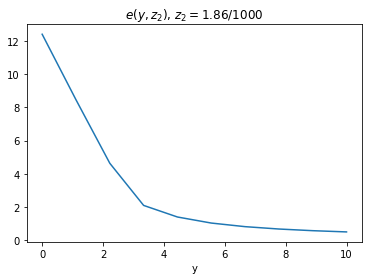

In [83]:
plt.plot(y_grid, e_grid[5])
plt.xlabel('y')
plt.title(r'$e(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, 1)

In [ ]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [ ]:
T = 100
Et = simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=T)

In [ ]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')

## SCC computation

$$
SCC = ME(y, z_2) \frac{(\alpha-i^*)\exp(k-n)}{\delta(1-\eta)}
$$

In our uncertainty decompositions, we compute $ME$ in the following four steps:

i) compute
$$
ME_1(y, z_2) = (1-\eta)\left(\sum_{j=1}^J\pi_jz_2\frac{d}{d \tau}\Lambda_j (y)\right)
$$

ii) construct
$$
U(y, z_2) = (1-\eta) \left[\sum_{j=1}^J\pi_jz_2^2 \frac{d^2}{d\tau^2}\Lambda_j (y) e^*(y, z_2)\right]
$$

iii) solve
$$
0 = -\delta f + \frac{\partial f}{\partial y}e^* + \frac{\partial f}{\partial z_2}\left[-\rho(z_2 - \sum_{j}^J \pi_j\mu_{2,j})\right] + \left[\frac{\partial^2 f}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

iv) then $ME_2(y, z_2)=f(y, z_2)$, and $ME(y, z_2) = ME_1(y, z_2) + ME_2(y, z_2)$